In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from luminosity import surface_brightness
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
%load_ext line_profiler

In [3]:
def bounding_box(snap):
    unit = snap['pos'].units
    for coord in 'x y z'.split():
        print("{}: {:10.2f}, {:10.2f} ({})".format(coord, snap[coord].min(), snap[coord].max(), unit))
    return [(float(snap[coord].min()), float(snap[coord].max())) for coord in 'x y z'.split()]

In [4]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [5]:
max_boxsize = 4000

In [6]:
s.properties['boxsize'] = pynbody.units.Unit("{} kpc".format(max_boxsize))

In [13]:
width = 9
resolution = 200

In [14]:
pynbody.analysis.halo.center(s.s)#, vel=False)
# pynbody.analysis.angmom.sideon(s.s)

In [15]:
subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-10))]

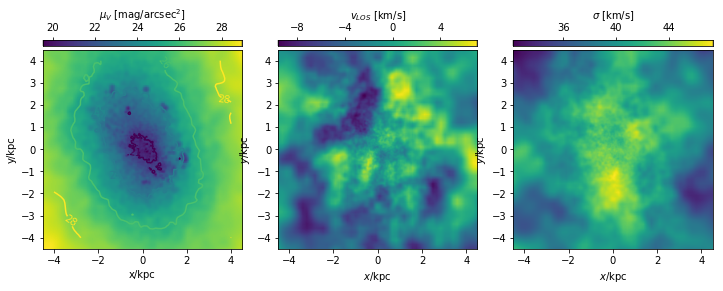

In [18]:
fig = plt.figure(figsize=(12,4))
grid = AxesGrid(fig, 111,  # similar to subplot(142)
                nrows_ncols=(1, 3),
                axes_pad=0.9,
#                 share_x=True,
#                 share_all=False,
                label_mode="all",
                cbar_mode="each",
                cbar_location="top",
                cbar_size="3%",
                cbar_pad="2%"
               )

v = 10
w=width

noplot=False
sb = surface_brightness(subsnap.s, band='v', width=8, resolution=500, isophotes=5, noplot=noplot,
                   mag_filter=None, subplot=grid[0], cax=grid.cbar_axes[0])

vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=w, resolution=resolution, noplot=False, log=False,
                           vmin=-v, vmax=v, show_cbar=False, subplot=grid[1])

sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=w, resolution=resolution, noplot=False, log=False,
                               vmin=-v, vmax=v, show_cbar=False, subplot=grid[2])

extent = (-width/2, width/2, -width/2, width/2)
def plot_lambda(sb, vlos, sigma):
    a = grid[0].imshow(sb, extent=extent, origin='lower')
    b = grid[1].imshow(vlos, extent=extent, origin='lower')
    
    cb2 =  grid.cbar_axes[1].colorbar(b)
    cb2.set_label_text("$v_{LOS}$ [km/s]")
    c = grid[2].imshow(sigma, extent=extent, origin='lower')

    cb3 = grid.cbar_axes[2].colorbar(c)
    cb3.set_label_text("$\sigma$ [km/s]")
plot_lambda(sb, vlos, sigma)

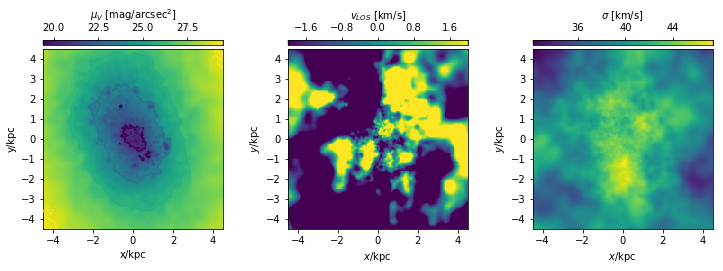

In [19]:
def adjust_cbar_range(cbar_range):
    if cbar_range is not None:
        if isinstance(cbar_range, (list, tuple) ) and len(cbar_range) == 2:
            m, M = cbar_range
        else:
            m, M = -cbar_range, cbar_range
    else:
        return None, None
    return m, M

def plot_maps(subsnap, width, resolution, v_los_range=None, sigma_range=None):
    fig = plt.figure(figsize=(12,4))
    grid = AxesGrid(fig, 111,  # similar to subplot(142)
                    nrows_ncols=(1, 3),
                    axes_pad=0.9,
    #                 share_x=True,
    #                 share_all=False,
                    label_mode="all",
                    cbar_mode="each",
                    cbar_location="top",
                    cbar_size="3%",
                    cbar_pad="2%"
                   )

    v_los_min, v_los_max = adjust_cbar_range(v_los_range)
    sigma_min, sigma_max = adjust_cbar_range(sigma_range)

    noplot=False
    sb = surface_brightness(subsnap.s, band='v', width=width, resolution=resolution, isophotes=5, noplot=noplot,
                       mag_filter=None, subplot=grid[0], cax=grid.cbar_axes[0])

    vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=width, resolution=resolution, noplot=False, log=False,
                                  show_cbar=False, subplot=grid[1])

    sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=width, resolution=resolution, noplot=False, log=False,
                                   show_cbar=False, subplot=grid[2])

    extent = (-width/2, width/2, -width/2, width/2)
    a = grid[0].imshow(sb, extent=extent, origin='lower')
    b = grid[1].imshow(vlos, extent=extent, origin='lower', vmin=v_los_min, vmax=v_los_max)
    
    cb2 =  grid.cbar_axes[1].colorbar(b)
    cb2.set_label_text("$v_{LOS}$ [km/s]")
    c = grid[2].imshow(sigma, extent=extent, origin='lower', vmin=sigma_min, vmax=sigma_max)

    cb3 = grid.cbar_axes[2].colorbar(c)
    cb3.set_label_text("$\sigma$ [km/s]")
    return grid
plot_maps(subsnap, width, resolution, v_los_range=2, sigma_range=None);

In [12]:
# %lprun -f plot_maps plot_maps(subsnap, width, resolution, v_los_range=2, sigma_range=None)

In [13]:
half_light_radius = pynbody.analysis.luminosity.half_light_r(s, cylindrical=False)
half_light_radius

SimArray(1.24955014, 'kpc')

In [14]:
def plot_angmom(snap, ax):
    """Plot the projected angular momentum on the map on `ax`, after having
    normalized it to one. It means that short arrows plotted means L almost
    aligned with line-of-sight-direction."""
    L = pynbody.analysis.angmom.ang_mom_vec(snap)
    print("L:", L)
    norm = np.linalg.norm(L)
    ax.arrow(0, 0, L[0]/norm, L[1]/norm, head_width=0.2, head_length=.2, color='red');

In [15]:
max_r = 10 * half_light_radius
radius_slider = ipywidgets.IntSlider(min=0, max=max_r, value=5, description='Width of the Cuboid', continuous_update=False)
width_slider = ipywidgets.IntSlider(min=0, max=max_r, value=width, description='Width', continuous_update=False)
vel_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5, description='limits for $v$', continuous_update=False)
sigma_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5, description='limits for $\sigma$', continuous_update=False)
v_button = ipywidgets.Checkbox(
    value=True,
    description='set v imits',
)
def k(snap, r, w, v, sig):
    subsnap = snap[pynbody.filt.Cuboid('{} kpc'.format(-r))]
    print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    pynbody.analysis.angmom.faceon(subsnap.s)
    grid = plot_maps(subsnap, w, resolution, v_los_range=v, sigma_range=sig)
    plot_angmom(subsnap.s, grid[0])

w = ipywidgets.interactive(k, snap=ipywidgets.fixed(s), r=radius_slider, w=width_slider, v=vel_slider, sig=sigma_slider)
# output = w.children[-1]
from ipywidgets import VBox, HBox
from IPython.display import display
print(w.children)
up_box = HBox(w.children[0:2])
down_box = HBox([*(w.children[2:4]), v_button])
# out_box = HBox([w.children[-1]])
all_ = VBox([up_box, down_box, w.out])
w.out.layout.height = '350px'
# def on_value_change(change):
#     print(change)
# ipywidgets.dlink((v_button, 'value'), (vel_slider, 'disabled'));

# See the traitlets available with target1.class_trait_names()

def disable_v(change):
    vel_slider.disabled = change['new']
v_button.observe(disable_v, names='value')
display(all_)


(IntSlider(value=5, continuous_update=False, description='Width of the Cuboid', max=12), IntSlider(value=8, continuous_update=False, description='Width', max=12), IntSlider(value=10, continuous_update=False, description='limits for $v$', step=5), IntSlider(value=10, continuous_update=False, description='limits for $\\sigma$', step=5), Output())


In [ ]:
a = ipywidgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

In [64]:
caption = ipywidgets.Label(value='Changes in source values are reflected in target1')
source, target1 = ipywidgets.ToggleButton(description='Source'),\
                  ipywidgets.IntSlider(description='Target 1')
dl = ipywidgets.dlink((source, 'value'), (target1, 'disabled'))
display(caption, source, target1)

Label(value='Changes in source values are reflected in target1')

ToggleButton(value=False, description='Source')

IntSlider(value=0, description='Target 1')

In [103]:
but = ipywidgets.ToggleButton(description='active', value=True)
other_range = ipywidgets.IntSlider()
display(but, other_range)
out = ipywidgets.Output()
display(out)

@out.capture()
def disable_slider(change):
    other_range.disabled = not(change['new'])
    but.description = str(change['new'])
    other_range.value = -1
    print(change['new'])
#     other_range.visible = but.value

but.observe(disable_slider, names='value')

ToggleButton(value=True, description='active')

IntSlider(value=0)

Output()

In [104]:
other_range.value

0

In [71]:
def ss_angmom(flux, r, v_los, v_disp):
    return np.sum(flux * r * np.abs(v_los)) / np.sum(flux * r * np.sqrt(v_los**2 + v_disp**2))
def compute_stellar_specific_angmom(snap, width, resolution, radii, eccentricity, a_delta, theta):
    luminosity_sim = surface_brightness(snap.s, band='v', width=width, resolution=resolution, mag_filter=None, cmap_name='Greys')
    v_los_sim = pynbody.plot.sph.image(snap.s, qty='vz', av_z=True, width=width, resolution=resolution, log=False)
    v_disp_sim = pynbody.plot.sph.image(snap.s, qty='v_disp', av_z=True, width=width, resolution=resolution, log=False)
    lum = to_astropy_quantity(luminosity_sim, units='mag/arcsec**2')
    v_los = to_astropy_quantity(v_los_sim)
    v_disp = to_astropy_quantity(v_disp_sim)
    lum_annuli = integrate_annulus(lum, center, radii, eccentricity, a_delta, theta)
    v_los_annuli = integrate_annulus(v_los, center, radii, eccentricity, a_delta, theta)
    v_disp_annuli = integrate_annulus(v_disp, center, radii, eccentricity, a_delta, theta)
    stellar_specific_angmom = ss_angmom(lum_annuli, radii, v_los_annuli, v_disp_annuli)
    return stellar_specific_angmom

In [11]:
max_r = 10 * half_light_radius
radius_slider = ipywidgets.IntSlider(min=0, max=max_r, value=5)
width_slider = ipywidgets.IntSlider(min=0, max=max_r, value=width)
vel_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5)

def k(r, w, v):
    subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-r))]
#     print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    pynbody.analysis.angmom.sideon(subsnap.s)
#     print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    figsize=None#(6,6)
    fig1, ax1 = plt.subplots(figsize=figsize)
    vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=w, resolution=resolution, log=False,
                           vmin=-v, vmax=v, show_cbar=True, subplot=ax1)
    
    fig2, ax2 = plt.subplots(figsize=figsize)
    sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=w, resolution=resolution, log=False,
                           show_cbar=True, subplot=ax2)

#     cbar2 = cb2.figure.colorbar(sigma);
#     cbar2.set_label('{} [{}]'.format("$\sigma", subsnap.s['v_disp'].units));
    fig3, ax3 = plt.subplots(figsize=figsize)
    flux = surface_brightness(subsnap, width=w, resolution=resolution, subplot=ax3, show_cbar=True);
#     cmap = plt.get_cmap(cmap_name)
#     cmap.set_bad('black')
#     cbar3 = cb3.figure.colorbar(flux);
#     cbar3.set_label('{} [mag/arcsec$^2$]'.format(band.upper()));    
w = ipywidgets.interactive(k, r=radius_slider, w=width_slider, v=vel_slider, show_cbar=False)
w

interactive(children=(IntSlider(value=5, description='r', max=12), IntSlider(value=8, description='w', max=12)…